# Mvalue AS classification

#### Here we evaluate As classification algorithm bu evaluating the value of alpha
#### M = (OnlyInNet + OnlyOutNet + SymmNet) * alpha 

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import plotly 
import plotly.graph_objs as go
import plotly.express as px
from IPython.display import HTML
from IPython.display import display
import os
import re
import glob
import fnmatch
from datetime import date, datetime

import matplotlib.pyplot as plt
import seaborn as sns
import timeit

from pandarallel import pandarallel
import argparse
import sys

In [2]:
import collections

import numpy as np
import pandas as pd
from pandas import *
from numpy import int64,float64

import os
import sys
import glob
import subprocess
import paramiko
import time
from datetime import datetime, timedelta, date

import seaborn as sns
import plotly 
import plotly.graph_objs as go
from IPython.display import HTML
import plotly.express as px
import plotly.io as pio
pio.renderers.default='iframe'  # Dont forget: to use plotly MUST set
pio.renderers.default = 'browser'
pio.renderers.default = 'svg'


import re
import json
from pprint import pprint
import requests
import cfscrape
from lxml import etree
from bs4 import BeautifulSoup
import requests
from pandas import json_normalize

# import pyspark
# from pyspark.sql.types import *
# import pyspark.sql.functions as F
# from pyspark.sql.functions import input_file_name, regexp_extract, split, col, lit, udf 
# import functools

# GLOBALS

In [3]:
RES="results/result_table_ases_up_and_open.csv"
CLASSIF='results/as_classification.csv'     #ONE DAY (1may2022 of AS_Classification)
#IMG='/Users/bertholdo/PAPERS/tnsm2023/leandro/'
IMG='./FIG/'
HIT_IX='dataset/2022-05-01_hitlist_ixroute.csv.gz'
IPGEO_CSV_OUT = "dataset/ip2loc.csv.gz" # look at bacaspy/ipgeo

In [4]:
pd.set_option('display.max_rows', 10)

# FUNCTIONS

## Object Store

In [5]:
'''
Download NEWEST FILE from a DACS OBJECTSTORE repository
usage: get_newest_file_s3('traces','Feeds/2022/ip2location/','/tmp/ip2loc.tar.gz')
'''
import boto3
import datetime 
import os
from botocore.utils import fix_s3_host

def get_newest_file_s3(bucket_name, bucket_folder, local_filename=None):
    
    s3 = boto3.resource( # can also replace resource with client if you need that
    's3',
    "nl-utwente",
    aws_access_key_id="xxxxxxxxxxxx",
    aws_secret_access_key="xxxxxxxxxxxxxxx",
    endpoint_url='https://object.dacs.utwente.nl'
    )
    # next line is needed to prevent some request going to aws instead of our server
    s3.meta.client.meta.events.unregister('before-sign.s3', fix_s3_host)

    
    bucket = s3.Bucket(bucket_name)  
    
    #select newest file
    last_modified_date = datetime.datetime(1939, 9, 1).replace(tzinfo=None)
    last_filename=None
    for obj in bucket.objects.filter(Prefix=bucket_folder):
            #print(obj.key, obj.last_modified)
            file_date = obj.last_modified.replace(tzinfo=None)
            if last_modified_date < file_date:
                last_modified_date = file_date
                last_filename = obj.key
    #print(last_filename, last_modified_date)
    
    #download from s3 to local
    if not local_filename:
        local_filename=os.path.basename(last_filename)
    print (f'{last_filename} --> {local_filename}')
    bucket.download_file(last_filename, local_filename)   


## IPGeolocation 

In [6]:
def read_ipgeo_csv (filename):
    #filename='./ip2loc/ip2loc.csv.gz'
    
    ip2loc_dtype= {"start_ip":"Int64", "end_ip":"Int64", "cc":"object", "extended_cc":"object", 
               "state":"object", "city":"object" , "lat":"float64", "long":"float64",
               "company":"object", "domain_name":"object", "mcc":"object", "mnc":"object", 
               "mobile_brand":"object", "usage_type":"object"}
    
    
    ipgeo=pd.read_csv(filename, keep_default_na=False, dtype=ip2loc_dtype)
    return ipgeo

## Graphs

In [7]:
# DFSUM = [ixp,date,policy,probed,net_sym,net_asy,asn_probed,asn_neig_probed,asn_asy,asn_neig_asy,asn_sym,asn_neig_sym]


def plot_asym_basic ( netasn, dfsum ):
    df = dfsum[['ixp','tipo', netasn]].groupby(['ixp','tipo']).mean().reset_index()
    
    # sort dfsum to barplot
    ordem = {'coverage23_in':0, 'sym24':1, 'sym23':2, 'asy23_just_in':3, 'asy24_just_in':4, 'asy23_just_out':5, 'asy24_just_out':6}
    df['ordem'] = df['tipo'].map(ordem)
    df = df.sort_values(['ixp','ordem'])
    df = df.drop(labels=['ordem'],axis=1)
    
    ix_list = df['ixp'].unique().tolist() 
    for ixp in ix_list:
        tit = '{} by Asymmetry type'.format(ixp.upper())
        ax = df[df['ixp']==ixp][['tipo', netasn]].plot.bar(x='tipo',rot=10, title=tit, figsize=(8,3))
        ax.legend(loc='best',bbox_to_anchor=(1.0, 0.5))
        ax.set_xlabel("asymmetry type")
        if netasn=='net':
            ax.set_ylabel("Number of Networks")
        elif netasn =='asn':
            ax.set_ylabel("Number of ASNs")
        else:
            print ('ERRO::: wrong parameter')
            
        fname = cfg.IMAGES_DIR + 'sym_basic_' + netasn +'_'+ ixp + '.pdf'
        #print (fname)

        plt.savefig(fname, bbox_inches='tight')
        plt.show()

In [8]:
def plot_business ( netasn, dfsum ):
    usage        = ['-', 'SES', 'COM', 'MOB', 'ORG', 'EDU', 'ISP', 'LIB', 'CDN', 'DCH', 'GOV', 'ISP/MOB', 'RSV', 'MIL']
    ix_test      = ['asy24_just_out', 'asy24_just_in', 'asy23_just_out', 'asy23_just_in']
    column_names =  ixinfo + usage + ['aslist'] 

    # group all IXP/TIPO measurements using MEAN
    df = dfsum.groupby(['ixp','tipo']).mean().reset_index()

    # sort dfsum to barplot
    ordem = {'coverage23_in':0, 'sym24':1, 'sym23':2, 'asy23_just_in':3, 'asy24_just_in':4, 'asy23_just_out':5, 'asy24_just_out':6}
    df['ordem'] = df['tipo'].map(ordem)
    df = df.sort_values(['ixp','ordem'])
    df = df.drop(labels=['ordem'],axis=1)
    
    netasn='asn'  ### fixo por enquanto - nao gerei o dafaframe pra net em asymmetry bu type of business
    ix_list = df['ixp'].unique().tolist() 
    for ixp in ix_list:
        tit = '{} by Asymmetry by Organization type'.format(ixp.upper())
        
        #fig = plt.figure(1)
        #ax = fig.add_subplot(111)
        ax = df[df['ixp']==ixp].plot.bar(x='tipo',rot=10, title=tit, figsize=(10,4))

        #handles, labels = ax.get_legend_handles_labels()
        lgd = ax.legend(loc='best',bbox_to_anchor=(1.0, 1.0))
        
        ax.set_xlabel("asymmetry type")
        if netasn=='net':
            ax.set_ylabel("Number of Networks")
        elif netasn =='asn':
            ax.set_ylabel("Number of ASNs")
        else:
            print ('ERRO::: wrong parameter')
            
        fname = cfg.IMAGES_DIR + 'sym_business_' + netasn +'_'+ ixp + '.pdf'
        ##print (fname)
        ##plt.savefig(fname, bbox_extra_artists=(lgd), bbox_inches='tight')
        #plt.savefig(fname, bbox_inches='tight')
        plt.show()

## Filter dataframes

In [9]:
def result_view(tipo, netasn, pfxsize):
    '''return a dataframe with result_table view based on RES(result_table):
    usage: df=result_view('asy','asn','24')
    tipo: asy,any,exc
    netasn: net, asn
    pfxsize: 24,23'''

    # Read result_table just fist time
    global dfall
    if 'dfall' not in globals():
        print (f'Reading {RES}')
        dfall=pd.read_csv(RES)
        dfall['date'] = pd.to_datetime(dfall['date']).dt.date
    
    # select columns
    method = tipo+pfxsize
    df = dfall[dfall['method']==method]
    select=[netasn, pfxsize]
    col=['ixp','date']
    col.extend([col for col in df.columns if all(x in col for x  in select) ])
    col=[x for x in col if not x.startswith('qt_asn_nonetworks') and not x.startswith('qt_asn_onlydiscard')]
    
    return df[col]

In [10]:
def class_view(tipo=None): #(tipo, netasn, pfxsize):
    '''return a dataframe with AS_CLASSIFICATION adding USAGE_TYPE from ipgeo(need to load first)
    Fix date, portuguese words, ixp names
    tipo: asy,any,exc
    netasn: net, asn
    pfxsize: 24,23'''

    # Read result_table just fist time
    global dfcla
    if 'dfcla' not in globals():
        print (f'Reading {CLASSIF}')
        dfcla=pd.read_csv(CLASSIF)
        dfcla['date'] = pd.to_datetime(dfcla['date']).dt.date
        # standarize dataframe
        dfcla['ixp']=dfcla['ixp'].apply(map_tangled_to_IXP_names)
        dfcla.loc[dfcla['type']=='Híbrido','type']='hybrid'
        dfcla.loc[dfcla['type']=='Somente Descartes','type']='onlydiscard'
        dfcla.loc[dfcla['type']=='Sem Redes na Amostra','type']='no_sample'
        
        # JOIN USAGE_TYPE from ipgeo
        usage = pd.read_csv('results/asn_usage.csv.gz')
        dfcla = pd.merge(dfcla, usage,  how="left", left_on=['asn'], right_on=['ASN'])
        # if classification have some ASN not it my usage_list set UNKNOWN
        dfcla['usage_type'] = dfcla['usage_type'].fillna('UNK')
    
    # select columns
    #method = tipo+pfxsize
    #df = dfall[dfall['method']==method]
    #select=[netasn, pfxsize]
    #col=['ixp','date']
    #col.extend([col for col in df.columns if all(x in col for x  in select) ])
    #col=[x for x in col if not x.startswith('qt_asn_nonetworks') and not x.startswith('qt_asn_onlydiscard')]
    #col=dfcla.columns

    # Filters
    df = dfcla
    #df = df[df['is_up_and_open']=='S']
    df = df[df['type']!='no_sample']
    if tipo:
        df=df[df['type']==tipo]
    
    col = ['ixp', 'asn', 'as_name', 'method', 'type', 'total_nets', 'total_nets_without_discards', 'usage_type']
    return df[col]

# Specific functions for alpha graph

In [11]:
def extract_number(string):
    """
    Extracts the first number from a given string using regular expressions.
    Args: string (str): The input string to extract the number from.
    Returns: int: The first number found in the input string, or None if no number is found.
    """
    #match = re.search(r'\d+', string)
    match = re.search(r'-?\d+', string)
    if match:
        return int(match.group())
    else:
        return None

In [12]:
def subtract_first_column(row):
    return row - row[-0.1]

def alpha_dia(dia='2022-04-17 00:00:00', metodo='asy24', tipo='qt_asn_hib24'):
    """
    read result_tables provided by PowerBI algorithm implementation and return a dataframe 
    with IXP and Alpha values from the asymmetry algorithm.
    Args: Day, method, type to analyse (eg. formula/formula23)
    Returns: Plotly figure with Alpha value and Hibrid ASes correlation
    """
    # Define the folder path
    folder_path = 'results/alpha/result_tables'
    # Initialize an empty dictionary to hold the dataframes
    ixp_dfs = {}

    # Loop through each file in the folder
    for file_name in os.listdir(folder_path):
        alpha = extract_number(file_name)
        # Check if the file is a CSV file
        if file_name.endswith('.csv'):
            #print(folder_path,file_name)
            # Construct the full file path
            file_path = os.path.join(folder_path, file_name)
            # Load the CSV file into a pandas dataframe
            df = pd.read_csv(file_path, low_memory=False)
            ixp = df['ixp'].iloc[0]  # Extract the value of the ixp column
            # if tipo == 'sampled': #ASes we have any sample
            #     # replace 
            #     aux = {'qt_asn_nonetworks24': [235.0, 26.0, 26.0, 17.0, 17.0]}
            #     index = ["spoixbr", "amsix", "linx", "poaixbr", "six"]
            #     df_aux = pd.DataFrame(aux, index=index)
            #     #df['qt_asn_nonetworks24']=df_aux[-0.01]
            #     #display(df)
            #     df['sampled']=df['nei_asn24']-df['qt_asn_onlydiscard24']
            #     #display(df['sampled']-df_aux['qt_asn_nonetworks24'])
            # # create total asym = qt_net_asy24_in + qt_net_asy23_in
            # if tipo == 'symdiference':
            #     # not finished just test
            #     df['symdiference'] = df['nei_asn24']-df['qt_asn_onlydiscard24']-df['qt_asn_sym24']-df['qt_asn_asy24_in']-df['qt_asn_asy24_out']#-df['qt_asn_hib24']#-df['qt_asn_nonetworks24']
            #     #df['symdiference'] = df['qt_asn_sym24']
            #     #df_totnei = df['nei_asn24'] - df['qt_asn_onlydiscard24']
            #     #df_tot = df[ (df['method'] == 'asy24') & (df['date'] == dia) ][['ixp', 'qt_asn_sym24']]
            #     #df_tot = df_tot.set_index('ixp')
            #     #display(df_tot)

            if tipo == 'formula':
                df['formula'] = df['qt_asn_hib24'] / \
                    (df['qt_asn_asy24_in'] + df['qt_asn_asy24_out'] + df['qt_asn_sym24'])
            if tipo == 'formula23':
                df['formula23'] = df['qt_asn_hib23'] / \
                    (df['qt_asn_asy23_in'] + df['qt_asn_asy23_out'] + df['qt_asn_sym23'])
            # Select the data and append it to the dictionary of dataframes
            alpha_df = df[(df['method'] == metodo) & (
                df['date'] == dia)][['ixp', tipo]]
            alpha_df = alpha_df.rename(columns={tipo: alpha})
            if ixp not in ixp_dfs:
                ixp_dfs[ixp] = alpha_df
            else:
                ixp_dfs[ixp] = ixp_dfs[ixp].merge(
                    alpha_df, on='ixp', how='outer')

    # check ixp_dfs
    #print(ixp_dfs)
    
                
    # Concatenate the dictionary of dataframes into a single dataframe
    data = pd.concat(ixp_dfs.values(), ignore_index=True)
    sorted_cols = sorted(
        data.columns[1:], key=lambda x: (x == 'ixp', int(x)))
    sorted_cols = ['ixp'] + sorted_cols
    data = data[sorted_cols]
    data = data.set_index('ixp')
    data = data.sort_values([10], ascending=False)
    data.columns = data.columns/100
    
    #if tipo == 'symdiference':
        #display(data)
        #display(df_tot)
        #data = data.apply(subtract_first_column, axis=1)
        #data = data/df_tot  
        
    #display(data)
    return (data)

# How many percent the algorithm solves - considering just getting all networks samples in same class

In [13]:
# Calc how many ASes need to be classified using algorithm (nei_asn24-qt_asn_nonetworks24-qt_asn_onlydiscard24)
df1 = alpha_dia('2022-05-05 00:00:00','asy24','qt_asn_onlydiscard24')
df2 = alpha_dia('2022-05-05 00:00:00','asy24','qt_asn_nonetworks24')
df2[-0.01]=df2[0.00]
df3 = alpha_dia('2022-05-05 00:00:00','asy24','nei_asn24')
#display(df1, df2, df3)

# What the diference before apply algoritm and after for each IXP in percentage
df = (df3-df2-df1)
df = df[[-0.01,0.00]]
percentage_change = ((df[0.00] / df[-0.01]) - 1) * 100
(percentage_change-100).median()

-90.65934065934067

# MAIN

In [14]:
def alpha_graph(data, axisy_zoom=0):
    """
    Plotly figure with Alpha value and Hybrid ASes correlation 
    Args: dataframe in format [IXP, 0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100]
    axisy_zoom: limit the axis_y to a value (ex. 0.12, 150)
    Returns: figure 
    """
    # Create the plotly figure
    fig = go.Figure()
    
    # Add traces for each IXP
    for ixp in data.index:
        fig.add_trace(go.Scatter(x=data.columns, y=data.loc[ixp],mode='lines+markers', name=ixp))

    # Add the vertical line
    fig.add_shape(
        # Line Vertical
        go.layout.Shape(
            type='line',
            x0='0.5',
            y0=data.values.min(),
            x1='0.5',
            y1=data.values.max(),
            line=dict(
                color='black',
                width=2,
                dash='dash'
            )
        )
    )
    
   
    # Build Dict for xaxis and yaxis
    xaxis_dict = {
    'title': f"Alpha value ({chr(945)})",
    'title_font': {'size': 20, 'color': 'black'},
    'tickmode': "linear",
    'tick0': 0,
    'dtick': 0.1,
    'range': [0, 1.01],  # Added a bit of space after 1.0
    'tickfont': {'size': 20, 'color': 'black'},
    'tickcolor': 'black'
    }

    yaxis_dict = {
    'title': "Percentage of Hybrid AS Selection",
    'tickfont': {'size': 20, 'color': 'black'},
    'title_font': {'size': 20, 'color': 'black'},
    'tickcolor': 'black'
    }

    # Add the range to y-axis dict if axisy_zoom is not zero
    if axisy_zoom:
        yaxis_dict['range'] = [0, axisy_zoom]
        
    # Use Dicts to update_layout    
    fig.update_layout(
        xaxis=xaxis_dict,
        yaxis=yaxis_dict,
        template="plotly_white",
        width=800,
        height=400,
        margin={'l': 1, 'r': 1, 't': 1, 'b': 1},  # Added a bit of left and right margin
        legend={
            'x': 0.09,
            'y': 0.95,
            'traceorder': "normal",
            'font': {
                'family': "sans-serif",
                'size': 20,
                'color': "black"
            },
            'bordercolor': "black",
            'borderwidth': 1
        }
    )
    
    # Update x-axis and y-axis line color to black
    fig.update_xaxes(showline=True, linewidth=1.5, linecolor='black', mirror=True)
    fig.update_yaxes(showline=True, linewidth=1.5, linecolor='black', mirror=True)

    return fig


In [15]:
#Index(['date', 'method', 'ixp', 'nei_net24', 'nei_net23', 'nei_asn24',
#       'nei_asn23', 'qt_net_sym24', 'qt_net_sym23', 'qt_net_asy24_in',
#       'qt_net_asy23_in', 'qt_net_asy24_out', 'qt_net_asy23_out',
#       'qt_asn_sym24', 'qt_asn_sym23', 'qt_asn_asy24_in', 'qt_asn_asy23_in',
#       'qt_asn_asy24_out', 'qt_asn_asy23_out', 'qt_asn_hib24', 'qt_asn_hib23',
#       'qt_asn_onlydiscard24', 'qt_asn_onlydiscard23', 'qt_asn_nonetworks24',
#       'qt_asn_nonetworks23'],

In [16]:
print (IMG)

./FIG/


# Alpha graph percentual of ASes selected

### Re-run this cell if [MathJax] messagem appear in saved figure

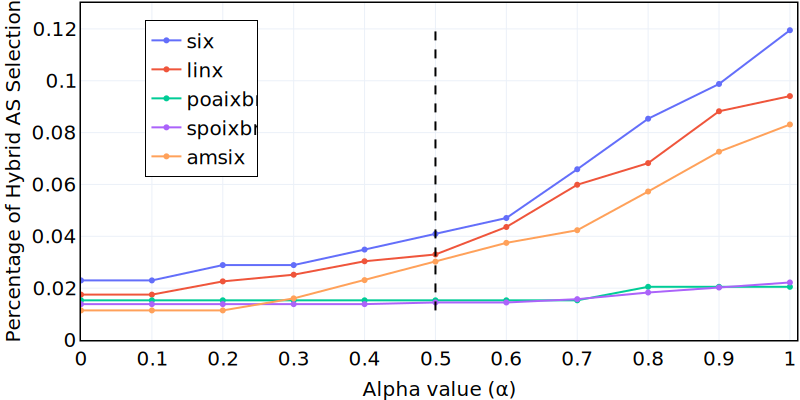

In [23]:
#data = alpha_dia('2022-05-05 00:00:00','asy24','qt_asn_sym24')
#data = alpha_dia('2022-05-05 00:00:00','asy24','symdiference')
#data = alpha_dia('2022-05-05 00:00:00','asy24','symdiference')
#data = alpha_dia('2022-05-05 00:00:00','asy24','qt_asn_hib24')
#data = alpha_dia('2022-05-05 00:00:00','asy24','qt_asn_sym24')
data = alpha_dia('2022-05-05 00:00:00','asy24','formula')
del data[-0.01]  #nao lembro mais porque precisava dessa coluns. So arrumei o grafico para impressao.
fig  = alpha_graph(data, axisy_zoom=0.13)

pio.renderers.default = 'browser'
pio.renderers.default = 'svg'
pio.write_image(fig, f'{IMG}/alpha-value.pdf', width=800, height=400, scale=1)

fig.show()

# Alpha graph NUMBER of ASes selected

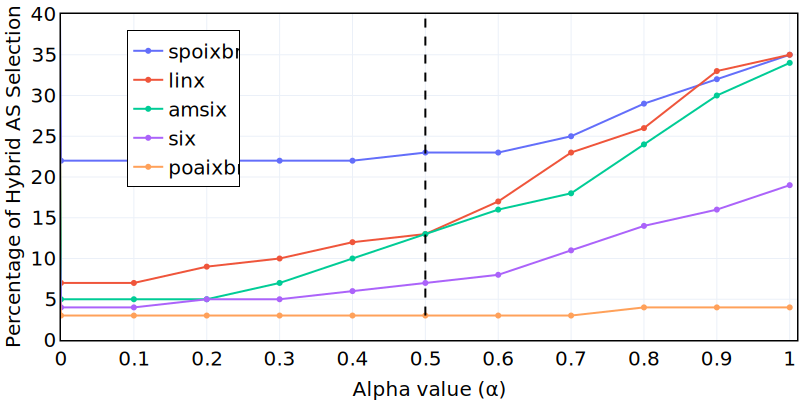

In [24]:
data = alpha_dia('2022-05-05 00:00:00','asy24','qt_asn_hib24')
fig  = alpha_graph(data, axisy_zoom=40)

# re-run this cell if [MathJax] messagem appear in saved figure
pio.renderers.default = 'browser'
pio.renderers.default = 'svg'
pio.write_image(fig, f'{IMG}/alpha-asn.pdf', width=800, height=400, scale=1)
fig.show()

In [19]:
data = alpha_dia('2022-05-05 00:00:00','asy24','qt_asn_sym24')
data

,-0.01,0.00,0.10,0.20,0.30,0.40,0.50,0.60,0.70,0.80,0.90,1.00
ixp,,,,,,,,,,,,
spoixbr,1371.0,1453.0,1453.0,1453.0,1453.0,1453.0,1453.0,1453.0,1451.0,1450.0,1449.0,1447.0
amsix,276.0,383.0,383.0,383.0,382.0,382.0,380.0,377.0,375.0,371.0,366.0,365.0
linx,227.0,342.0,342.0,341.0,340.0,338.0,337.0,334.0,328.0,326.0,322.0,321.0
poaixbr,173.0,186.0,186.0,186.0,186.0,186.0,186.0,186.0,186.0,186.0,186.0,186.0
six,102.0,143.0,143.0,142.0,142.0,142.0,141.0,141.0,140.0,139.0,137.0,134.0


In [20]:
#alpha_dia('2022-05-05 00:00:00','asy24','nei_asn24').sum()
alpha_dia('2022-05-05 00:00:00','asy24','qt_asn_nonetworks24')#[[0.00]]

,-0.01,0.00,0.10,0.20,0.30,0.40,0.50,0.60,0.70,0.80,0.90,1.00
ixp,,,,,,,,,,,,
spoixbr,NaN,235.0,235.0,235.0,235.0,235.0,235.0,235.0,235.0,235.0,235.0,235.0
amsix,NaN,26.0,26.0,26.0,26.0,26.0,26.0,26.0,26.0,26.0,26.0,26.0
linx,NaN,26.0,26.0,26.0,26.0,26.0,26.0,26.0,26.0,26.0,26.0,26.0
poaixbr,NaN,17.0,17.0,17.0,17.0,17.0,17.0,17.0,17.0,17.0,17.0,17.0
six,NaN,17.0,17.0,17.0,17.0,17.0,17.0,17.0,17.0,17.0,17.0,17.0


In [21]:
data.iloc[:,1:].div(data[-0.01], axis=0)-1*100

,0.0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0
ixp,,,,,,,,,,,
spoixbr,-98.940190,-98.940190,-98.940190,-98.940190,-98.940190,-98.940190,-98.940190,-98.941648,-98.942378,-98.943107,-98.944566
amsix,-98.612319,-98.612319,-98.612319,-98.615942,-98.615942,-98.623188,-98.634058,-98.641304,-98.655797,-98.673913,-98.677536
linx,-98.493392,-98.493392,-98.497797,-98.502203,-98.511013,-98.515419,-98.528634,-98.555066,-98.563877,-98.581498,-98.585903
poaixbr,-98.924855,-98.924855,-98.924855,-98.924855,-98.924855,-98.924855,-98.924855,-98.924855,-98.924855,-98.924855,-98.924855
six,-98.598039,-98.598039,-98.607843,-98.607843,-98.607843,-98.617647,-98.617647,-98.627451,-98.637255,-98.656863,-98.686275


In [22]:
df = data[[-0.01,0.00]]
percentage_change = ((df[0.00] / df[-0.01]) - 1) * 100
percentage_change

ixp
spoixbr     5.981036
amsix      38.768116
linx       50.660793
poaixbr     7.514451
six        40.196078
dtype: float64

# END